# Introduction

The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a standardized test used by many competetive colleges in the U.S. to determine, in part, which students to admit. Standardized tests as an admission tool, however, have recently been questioned due to their potential role in continuing racial, gender, and income inequality. In this project, we use data from New York City High Schools to investigate how various demographic factors impact SAT scores. 

Specifically, in this notebook, we do the following: 

- Extract information related to our problem from 7 different messy datasets

- Clean and combine the information into a single dataset

- Use this dataset to investigate important questions related to SAT scores

The highlight of this project is the data cleaning process, which takes place in the first two bullet points above. Specifically, answering real world questions with data often requires collecting messy data from multiple sources, and combining into a single clean dataset for analysis. In this project, we demonstrate this process. We also thoroughly explore some important questions regarding standardize testing inequality, such as the impact of race, as well as student perceived school safety, on test scores. 

# About the Data

The data used in this project can be found at the following links:

- [Advanced Placement Testing Data](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)

- [Class Size Data](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)

- [Demographic Data](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)

- [Graduation Outcome Data](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)

- [High School Directory Data](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2)

- [SAT Score Data](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)

- [Survey Data: from New York City district 75,  as well as all schools](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)

We've downloaded all datasets above and placed them in a folder titled "schools". We've also renamed them for convenience and consistency. 

Since we're investigating SAT scores from New York City Schools, there are a few general knowledge things, revealed by a quick glance at the data, to keep in mind throughout the data cleaning and analysis process:

- The SAT is a test taken primarily by High Schoolers. Information regarding other levels can be discarded. 

- New York City is separated into five boroughs. This gives a natural clustering on the high schools.

- A finer subdivision of schools into groups is by district. 

- Each school is uniquely identified by a District Borough Number, or DBN. 

Without further ado, let's continue to reading in the datasets. 

# Data Exploration and Cleaning 

Since we're working with multiple datasets, it will be useful to read each file in as a pandas dataframe, and store all dataframes into a single data dictionary. 

### Reading in .csv files

In [1]:
import pandas as pd
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}
for i,file in enumerate(data_files):
    file_key = file[:-4] #remove .csv in data dictionary
    if (i==0) or (i==1): 
        #ap_2010.csv and class_size are semicolon separated
        data[file_key] = pd.read_csv(f"schools_dirty/{file}", delimiter=';') 
    else:
        data[file_key] = pd.read_csv(f"schools_dirty/{file}") 


There are two other datasets which are .txt files. We'll look at those later. For now, since we've read in the .csv data, let's glimpse the first couple rows of each dataset. 

In [2]:
for key in data.keys():
    print(data[key].head())
    print('\n\n\n')

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management             NaN   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                  NaN  
2                26                                   24  
3               377                                  191  
4               NaN                                  NaN  




   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2 

A quick look at the output reveals the following key points:

- each dataset contains a DBN, with the exception of one dataset.

- The one exception has CSD and School Code, which when combined seems to make a DBN

- Hence, DBN can be used to combine the datasets. We also note that some datasets have dbn in lowercase. 

Before we try to combine the data, let's look at those .txt files we mentioned earlier. 

### Reading in .txt files

Looking at the .txt files, we see that entries are tab separated. Looking more closely, we can see that the files are encoding with windows-1252 encoding. We also see that the column names are identical. It makes most sense to combine these datasets by concatenating along the 0 axis. Hence, we can read these files into dataframes and combine them with the following code.

In [3]:
all_survey = pd.read_csv('schools/survey_all.txt',delimiter = '\t', encoding = 'windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt',delimiter = '\t', encoding = 'windows-1252')
survey = pd.concat([all_survey,d75_survey],axis = 0)
print(survey.head())

      dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p  ...  s_q14_2  \
0         0.0           Elementary School   NaN    88    60  ...      NaN   
1         0.0           Elementary School   NaN   100    60  ...      NaN   
2         0.0           Elementary School   NaN    88    73  ...      NaN   
3         0.0  Elementary / Middle School  89.0    73    50  ...      NaN   
4         0.0           Elementary School   NaN   100    60  ...      NaN   

   s_q14_3  s_q14_4  s_q14_5  s_q14_6  s_q14_7  s_q14_8  s_q14_9  s_q14_10  \
0      NaN      NaN 

We have over 2000 columns. Also, many columns seem to have a large number of missing values. A quick look at the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) reveals that only the following columns will be useful to us:

In [4]:
good_cols = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", 
            "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", 
            "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", 
            "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", 
            "eng_tot_11", "aca_tot_11"]

We've added a column "DBN" because the original dataset has the lower-case naming "dbn" which is not consistent with the other datasets. In the following code cell, we first add a DBN column to survey, which is a copy of the dbn column. Then, we restrict to the good columns, and add survey to the data dictionary. 

In [5]:
survey['DBN'] = survey['dbn']
survey = survey[good_cols]
data['survey'] = survey

/tmp/ipykernel_397/705155496.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey['DBN'] = survey['dbn']


Before moving on to create a DBN for the expeption, let's fix the instance of a lowercase dbn column. Looking at the previous output, we see that the hs_directory dataframe is the culprit. For now, let's just add in a DBN column.  

In [6]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn'] 

### Creating DBN 
Earlier, we noticed that the class_size dataframe is missing a DBN. Let's take a closer look. 

In [7]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15,1.0,15.0,15.0,15.0,ATS,NaN


Initially, it seems that CSD and School code can combine to make a DBN. Let's look at some DBN's to see the difference. 

In [8]:
data['hs_directory']['DBN']

0      27Q260
1      21K559
2      16K393
3      08X305
4      03M485
        ...  
430    02M300
431    09X412
432    32K549
433    02M407
434    21K344
Name: DBN, Length: 435, dtype: object

We see that the DBN follows the format of two digits, followed by a school code. The first two digits correspond to the CSD. If the CSD is 2, for instance, and the school code is M300, then the DBN is 02M300. If the CSD is 1 digit, we need to pad it with a leading 0. Hence, we can eaily create a DBN for the class_size dataframe in two steps.

1. Create a padded CSD

2. Add the padded CSD with the School code to create a DBN

We perform these steps in the following code cell. 


In [9]:
data['class_size']['padded_CSD'] =  data['class_size']['CSD'].apply(
    lambda x: '0'+str(x) if len(str(x))<2 else str(x))
    
data['class_size']['DBN'] = data['class_size']['padded_CSD'] + data['class_size']['SCHOOL CODE']

Let's take a look at the new column to make sure it has the right format. 

In [10]:
data['class_size']['DBN']

0        01M015
1        01M015
2        01M015
3        01M015
4        01M015
          ...  
27606    32K564
27607    32K564
27608    32K564
27609    32K564
27610    32K564
Name: DBN, Length: 27611, dtype: object

This column looks good. We're ready to move on to creating some useful statistics with the sat_results dataframe. 

### SAT results: total score

Notice that the sat_results dataframe has scores on the individual sections. 

In [11]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


It may be helpful to create a total score. To do this, we'll simply convert each column to numeric, and then add them together. 

In [12]:
to_numeric_cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
#convert each score column to numeric 
for col in to_numeric_cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors = 'coerce')
#initialize a total score column 
data['sat_results']['sat_score'] = 0
#add up the three columns to create a total score 
for col in to_numeric_cols:
    data['sat_results']['sat_score'] += data['sat_results'][col]
    
print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


### Extracting school coordinates

The hs_directory dataframe contains information about the location of each high school. This could be helpful for visualizing any geographic trends in SAT scores. Let's take a look.

In [13]:
print(data['hs_directory']['Location 1'].head())

0    8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...
1    2630 Benson Avenue\nBrooklyn, NY 11214\n(40.59...
2    1014 Lafayette Avenue\nBrooklyn, NY 11221\n(40...
3    1980 Lafayette Avenue\nBronx, NY 10473\n(40.82...
4    100 Amsterdam Avenue\nNew York, NY 10023\n(40....
Name: Location 1, dtype: object


At the end of each location, we have (latitude, longitude). First, let's write a regex function that will match parentheticals, and extract the content. 

Recall the following regex patterns:

- . matches any caracter (except newline)
- .+ mathces any character 1 or more times
- \(.+\) extracts any character 1 or more times occuring between parentheses

We can then use string methods, such as string.replace(), to extract the longitude and latitude. 

In [14]:
import re
def extract_lat(string):
    coords = re.findall("\(.+\)", string)[0] #match desried regex pattern
    coords = coords.replace('(','') #remove parenthetical, commas
    coords = coords.replace(')','')
    coords = coords.replace(',','')
    coord_list = coords.split(' ') #create into list [latitude, longitude]
    latitude = coord_list[0]
    return latitude

def extract_lon(string):
    coords = re.findall("\(.+\)", string)[0] #match desried regex pattern
    coords = coords.replace('(','') #remove parenthetical, commas
    coords = coords.replace(')','')
    coords = coords.replace(',','')
    coord_list = coords.split(' ') #create into list [latitude, longitude]
    longitude = coord_list[1]
    return longitude

Let's use these functions to create new columns in the hs_directory, and convert them to numeric. 

In [15]:
#create lat and lon columns
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(extract_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(extract_lon)

#convert new columns to numeric
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors = 'coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors = 'coerce')

data['hs_directory'][['lat','lon']]

,lat,lon
0,40.601989,-73.762834
1,40.593594,-73.984729
2,40.692134,-73.931503
3,40.822304,-73.855961
4,40.773671,-73.985269
...,...,...
430,40.765027,-73.992517
431,40.840373,-73.910838
432,40.696962,-73.910816
433,40.732485,-73.983053


We're getting close to combining our data, but there are a few steps left. 

### Ensuring unique DBN

Since DBN's will be used to combine the data, we have to ensure this is unique. That is certainly not the case for all the dataframes. Let's check which dataframes have duplicated dbn's.  


In [16]:
for df in data.keys():
    print(f"nonunique values in {df}: {data[df]['DBN'].duplicated().any()}")

nonunique values in ap_2010: True
nonunique values in class_size: True
nonunique values in demographics: True
nonunique values in graduation: True
nonunique values in hs_directory: False
nonunique values in sat_results: False
nonunique values in survey: False


Let's take a closer look at each one, starting with class_size. 

#### class_size DBNs

In [17]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_CSD,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


We notice that there is a GRADE column. Since we are only analyzing high school data, we'll restrict to GRADE entries of '09-12'. Moreover, some grades have multiple program types. Since GEN ED is generally the largest, we'll further restrict to a single PROGRAM TYPE: GEN ED. 

In [18]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE ']=='09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
print(class_size.head())

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

We can immediately see that the DBN is still not unique. This is due to separate reporting for each course. To amend this, we'll first groupby DBN, and then report the mean value among each DBN for the columns. After this, we replace the class_size dataframe in the data dictionary with the cleaned version.

In [19]:
import numpy as np
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace = True)
data['class_size'] = class_size
print(data['class_size'].head())

      DBN  CSD  NUMBER OF SECTIONS  AVERAGE CLASS SIZE  \
0  01M292  1.0            4.000000           22.564286   
1  01M332  1.0            2.000000           22.000000   
2  01M378  1.0            1.000000           33.000000   
3  01M448  1.0            4.750000           22.231250   
4  01M450  1.0            2.733333           21.200000   

   SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0                   18.50              26.571429   
1                   21.00              23.500000   
2                   33.00              33.000000   
3                   18.25              27.062500   
4                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN  


Great! We see that we still have information from each column, but now DBN is unique. 

We still have a couple dataframe with nonunique values:

In [20]:
for df in data.keys():
    print(f"nonunique values in {df}: {data[df]['DBN'].duplicated().any()}")

nonunique values in ap_2010: True
nonunique values in class_size: False
nonunique values in demographics: True
nonunique values in graduation: True
nonunique values in hs_directory: False
nonunique values in sat_results: False
nonunique values in survey: False


Let's move onto cleaning the demographics data set. 

#### demographics DBNs

Let's look at the first few rows.

In [21]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


It's immediately clear that the "schoolyear" column is preventing the DBN from being unique. Since the SAT results correspond to years 2011-2012, we'll just restrict to these years. 

In [22]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]
print(data['demographics'].head())

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

#### graduation DBNs

Let's take a look at the DBN's corresponding to the 'graduation' dataframe. 

In [23]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1


We can see that the same DBN has different Cohort names. This likely corresponds to the year. Let's take a look. 

In [24]:
data['graduation']['Cohort'].value_counts()

2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64

We'll filter only using the most recent Cohort (2006). We want to make sure we look at the entire Cohort, and not some subset. Hence, we'll filter the Demographic column as well. 

In [25]:
data['graduation']=data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation']=data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']
print(data['graduation'].head())

     Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n  Total Grads - % of cohort Total Regents - n  \
3             78              43                       55.1                36   
10           124              53                       42.7                42   
17            90              70                       77.8                67   
24            84              47                       56.0                40   
31           193             105                       54.4                91   

    Total Regents - % of cohort  Total Regents - % of grads  ...  \


As we can see, we only have 1 dataframe containing nonunique values for DBN.

In [26]:
for df in data.keys():
    print(f"nonunique values in {df}: {data[df]['DBN'].duplicated().any()}")

nonunique values in ap_2010: True
nonunique values in class_size: False
nonunique values in demographics: False
nonunique values in graduation: False
nonunique values in hs_directory: False
nonunique values in sat_results: False
nonunique values in survey: False


Let's clean this dataframe, and then combine everything into a single dataframe. 

#### ap_2010 

Let's take a look at the first few rows. 

In [27]:
print(data['ap_2010'].columns.to_list())
data['ap_2010'].head()

['DBN', 'SchoolName', 'AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']


,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,NaN
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


The final three columns will be useful for analysis later on. Let's convert them to numeric for later. 

In [28]:
cols = data['ap_2010'].columns.to_list()[-3:] #get last three columns
#convert these columns to numeric
for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors = 'coerce') 
    
print(data['ap_2010'].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


Now, let's see which entries have identical DBNs. 

In [29]:
data['ap_2010'][data['ap_2010']['DBN'].duplicated(keep = False)]

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
51,04M610,THE YOUNG WOMEN'S LEADERSHIP SCHOOL OF EAST HA...,41.0,55.0,29.0
52,04M610,YOUNG WOMEN'S LEADERSHIP SCH,NaN,NaN,NaN


Clearly, this school was entered twice. The second entry has all of the important information missing, so we'll drop that one. 

In [30]:
ap_2010 = data['ap_2010']
ap_2010.drop(index = 52, inplace = True)
ap_2010.reset_index(inplace = True)
data['ap_2010'] = ap_2010

Now, all DBN's should be unique. Let's check this just in case. 

In [31]:
for df in data.keys():
    print(f"nonunique values in {df}: {data[df]['DBN'].duplicated().any()}")

nonunique values in ap_2010: False
nonunique values in class_size: False
nonunique values in demographics: False
nonunique values in graduation: False
nonunique values in hs_directory: False
nonunique values in sat_results: False
nonunique values in survey: False


Indeed, we have cleaned the data so that the DBN's are all unique! Now we can move on to combining the data. 

# Combining The Data

Since we're interested in how sat scores relate to various demographic and geographic infromation, we'll start with the sat_results dataframe, and left merge dataframes that contain information which may not be as important to our analysis, such as the ap_2010 and graduation dataframes.   

In [32]:
combined = data["sat_results"]
combined = combined.merge(data['ap_2010'],how = 'left')
combined = combined.merge(data['graduation'], how = 'left')
print(combined.head())
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  index  \
0                404.0                   363.0     1122.0    NaN   
1                423.0                   366.0     1172.0    0.0   
2                402.0                   370.0     1149.0    1.0   


For the remaining dataframes, information contained in each column will be important for our analysis. Hence, we only want to analyze schools with DBN's in combined, as well as the remaining dataframes. This suggests using an inner join. 

In [33]:
combined = combined.merge(data['class_size'], how = 'inner')
combined = combined.merge(data['demographics'], how = 'inner')
combined = combined.merge(data['survey'], how = 'inner')
combined = combined.merge(data['hs_directory'], how = 'inner')
print(combined.head())
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  index  \
0                404.0                   363.0     1122.0    NaN   
1                423.0                   366.0     1172.0    0.0   
2                402.0                   370

Now that we've combined our data, we have a number of missing values. Let's fill some of these. First, we'll fill with the means. We'll then fill any remaining missing values with 0. 

In [34]:
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)
print(combined.head())

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score       index  \
0                404.0                   363.0     1122.0  131.502203   
1                423.0                   366.0     1172.0    0.000000   
2                402.0       

/tmp/ipykernel_397/1913468206.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = combined.mean()


As a final step, we can create a column entitled "school_dist" which corresponds to the school district. Recall that we can extract the school district from the DBN via the first two characters. we perform this with string indexing in the following cell. 

In [35]:
combined['school_dist'] = combined['DBN'].apply(lambda x:x[0:2])
print(combined['school_dist'][0:5])

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


Let's take a look at the columns of the final dataframe. 

In [36]:
for col in combined.columns:
    print(col)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
index
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percent
sped_num
sped_percent
ctt_

This concludes the data cleaning process. We'll now use the above features to investigate potential sources of testing inequality. 

# Data Analyzation 
Let's begin by looking at how survey responses from parents, students, and teachers correlate with test scores.  

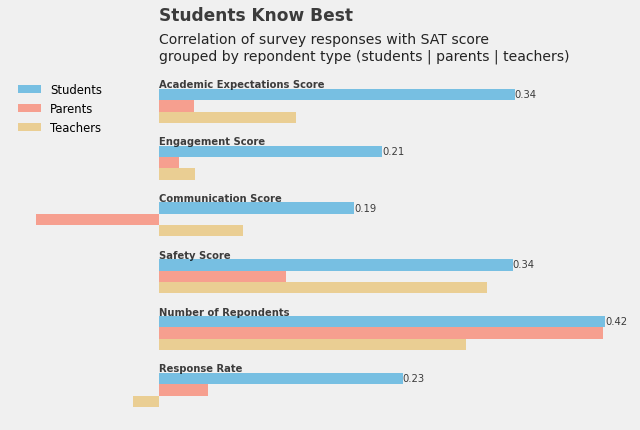

In [48]:
#create lists of survey fields based on respondent type (student|parent|teacher|total)
student_survey_fields = ["rr_s", 
    "N_s", 
    "saf_s_11",
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11"
]

teacher_survey_fields = ["rr_t", 
    "N_t", 
    "saf_t_11",
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11"
]

parent_survey_fields = ["rr_p", 
    "N_p", 
    "saf_p_11",
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11"
]
tot_survey_fields = [ 
    "saf_tot_11",
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11"

]
#Dictionary mapping feature names to intuitive names
survey_dictionary = {}
survey_dictionary["rr_s"] = "Response Rate"
survey_dictionary["N_s"] = "Number of Repondents"
survey_dictionary["saf_s_11"] = "Safety Score"
survey_dictionary["com_s_11"] = "Communication Score"
survey_dictionary["eng_s_11"] = "Engagement Score"
survey_dictionary["aca_s_11"] = "Academic Expectations Score"
#compute correlations for plotting
correlations = combined.corr()
correlations = correlations['sat_score']
#___________________________________________________________
#initialize plot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize = (10,6))
#___________________________________________________________
#generate main plot
x_axis = np.arange(len(student_survey_fields))
ax.barh(x_axis + .2,correlations[student_survey_fields], alpha = .5,height = .2,label = "Students")
ax.barh(x_axis,correlations[parent_survey_fields],alpha = .5,height = .2, label = "Parents" )
ax.barh(x_axis - .2,correlations[teacher_survey_fields],alpha = .5,height = .2, label = "Teachers")
#___________________________________________________________
#remove ticks and format legend
ax.grid(visible=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc = 'upper left', frameon = False, fontsize = 'small')
#___________________________________________________________
#create title and subtitle
ax.text(0,6.5, 'Students Know Best', weight = 'bold', size = 17, alpha = .75)
ax.text(0,6.1, 'Correlation of survey responses with SAT score', alpha = .85)
ax.text(0,5.8, 'grouped by repondent type (students | parents | teachers)', alpha = .85)
#___________________________________________________________
#place student correlation values, and put untuitive labels on top
for i, v in enumerate(correlations[student_survey_fields]):
    ax.text(v, i+.2, str(round(v,2)), color='black', fontsize=10, ha='left', va='center', alpha = .75)
    ax.text(0, i+.37, survey_dictionary[student_survey_fields[i]], color='black', weight = 'bold',alpha = .75, fontsize=10, ha='left', va='center')    
    

Interestingly, we see that student responses to every question on the survey correlate higher than the responses of teachers or parents. Looking more closely at the communication score, we see that parents perception of communication level is actually negatively correlated with SAT score. 

Let's take a closer look at the safety score section. The safety score represents how safe each respondent views the school. We see that student perception of safety is most highly correlated with SAT score. To get a closer look at how student perception of safety may affect test performance, let's plot SAT score vs. student perceived safety score. 

/tmp/ipykernel_397/1794323982.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','1000','','1400','','1800', '','2200'])


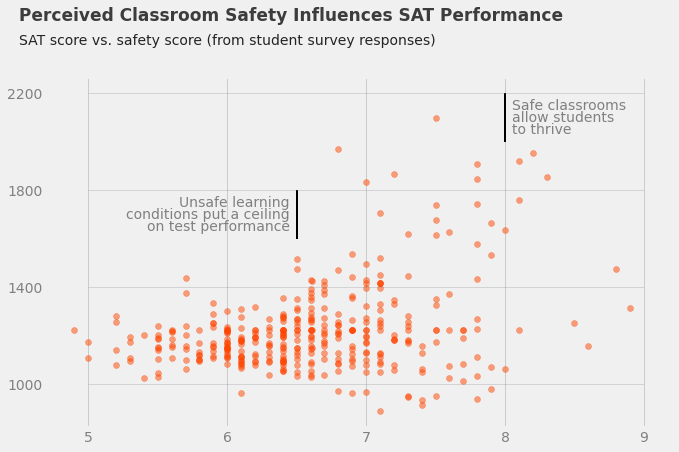

In [49]:
#initialize plot
fig,ax = plt.subplots(figsize = (10,6))
#___________________________________________________________
#create main plot
ax.scatter(combined["saf_s_11"], combined["sat_score"],color = "orangered", alpha = .5)
#___________________________________________________________
#remove grid
ax.grid(visible= False, axis = 'y')
#___________________________________________________________
#title and subtitle
ax.text(4.5,2500, 'Perceived Classroom Safety Influences SAT Performance', weight = 'bold', size = 17, alpha = .75)
ax.text(4.5,2400, 'SAT score vs. safety score (from student survey responses)', alpha = .85)
#___________________________________________________________
#emphasize low maximum for unsafe schools
ax.text(6.45,1750, 'Unsafe learning', color = 'grey', ha='right', va='center')
ax.text(6.45,1700, 'conditions put a ceiling', color = 'grey', ha='right', va='center')
ax.text(6.45,1650, 'on test performance', color = 'grey', ha='right', va='center')
ax.vlines(6.5, ymin = 1600, ymax = 1800,color = 'black',linewidth = 2)
#___________________________________________________________
#emphasize higher maximum for safe schools
ax.text(8.05,2150, 'Safe classrooms', color = 'grey', ha='left', va='center')
ax.text(8.05,2100, 'allow students', color = 'grey', ha='left', va='center')
ax.text(8.05,2050, 'to thrive', color = 'grey', ha='left', va='center')
ax.vlines(8, ymin = 2000, ymax = 2200,color = 'black',linewidth = 2)
#___________________________________________________________
#horizontal lines and grey tick parameters for visual
ax.tick_params(colors = 'grey', which = 'both')
ax.set_yticklabels(['','1000','','1400','','1800', '','2200'])
ax.hlines([1000,1400,1800,2200], xmin = 5,xmax=9, linewidth = .5, color = 'grey',alpha = .5)

We see that absolutely no schools with a student perceived safety score of 6.5 or less averaged higher than 1600 on the SAT. On the otherhand, almost every school with an average score of above 1600 had a student perceived safety score of 7.0 or greater. This suggests that classroom safety puts a ceiling on how well students are able to perform on the SAT. 

Let's take a closer look at the safety scores, to see which races are most affect by unsafe classrooms. 

Text(-15, 7.5, 'Racial demographics grouped by student perceived safety score')

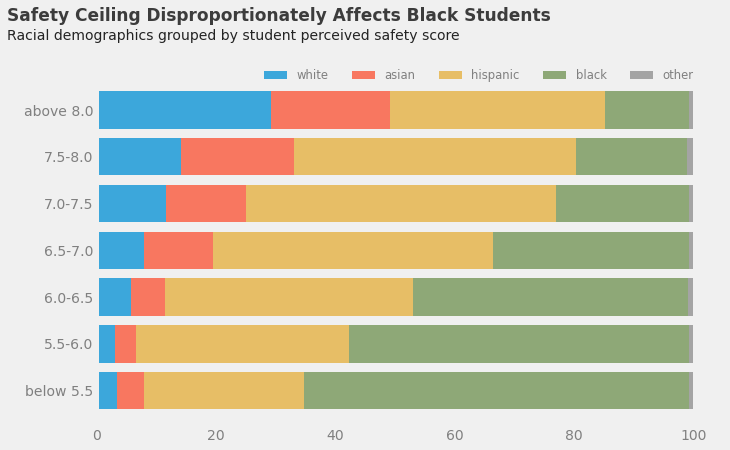

In [44]:
#___________________________________________________________
#extract desired features from combined DataFrame
race_per = ["white_per","asian_per","hispanic_per","black_per"]
race_df = combined.loc[:,race_per + ["saf_s_11"]]
#___________________________________________________________
#create labels for safety interval cateogries and intervals for averaging over
categories = ['below 5.5','5.5-6.0','6.0-6.5','6.5-7.0','7.0-7.5','7.5-8.0','above 8.0']
endpoints = [5.5,6,6.5,7,7.5,8]
#___________________________________________________________
#label each data point with appropriate category / bin 
race_df.loc[race_df['saf_s_11'] < endpoints[0],'bin'] = categories[0]
for i,item in enumerate(endpoints):
    if i < len(endpoints) - 1:
        race_df.loc[(item<=race_df["saf_s_11"]) & (race_df["saf_s_11"]<endpoints[i+1]) ,'bin'] = categories[i+1]
    else: 
        race_df.loc[race_df["saf_s_11"]>item, 'bin'] = categories[i+1]
#___________________________________________________________
#generate DataFrame for plotting 
#resulting dataframe contains category as its index, race as 
# its features, and mean percentage of race j in bin i as its 
#(i,j)-th entry
plot_data = pd.DataFrame([], columns=race_per, index=range(0,len(categories)))
for bin,cat in enumerate(categories):
    for race in race_per:
        plot_data.loc[bin,race] = np.round(race_df.loc[race_df.loc[:,'bin'] == cat, race].mean(),2) 
#add a feature for unaccounted races
plot_data['other_per'] = 100.00 - plot_data.sum(axis = 1)
#___________________________________________________________
#initialize plot
fig,ax = plt.subplots(figsize = (10,6))
x_axis = categories
#___________________________________________________________
#stack bars ontop of each other to create proprtional plot
for i,race in enumerate(race_per + ['other_per']):
    if i == 0:
         ax.barh(x_axis, plot_data[race], alpha = .75,label = race[:-4])
    else:
        #cumsum used here to make bars stack ontop of each other
        ax.barh(x_axis, plot_data[race], left = plot_data.cumsum(axis = 1).iloc[:,i-1],alpha = .75,label = race[:-4])
#___________________________________________________________
#remove grids and make ticks and labels grey, format legend
ax.tick_params(colors = 'grey', which = 'both')
ax.grid(visible= False, axis = 'y')
ax.grid(visible= False, axis = 'x')
leg = ax.legend(bbox_to_anchor=([0.25, .95, 0, 0]), ncol=5, frameon=False, fontsize = 'small')
#___________________________________________________________
#place title and subtitle
for text in leg.get_texts():
    text.set_color('gray')
ax.text(-15,7.9, 'Safety Ceiling Disproportionately Affects Black Students', weight = 'bold', size = 17, alpha = .75)
ax.text(-15,7.5, 'Racial demographics grouped by student perceived safety score', alpha = .85)

We see from this that black students tend to make up an increasingly smaller percentage of schools with a higher safety rating, while white and asian students grow in percentage as safety rating increases. This suggests that the performance ceiling put on test performance due to lack of safety affects more black and hispanic students than it does white students. Moreover, a larger percentage of white and asian students are able to benefit from schools with a high safety rating than black and hispanic students. 

It may also be illuminating to see how racial demographics differ among schools with varying SAT scores. 

/tmp/ipykernel_397/2974186592.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'])


Text(-15, 15.75, 'Racial demographics grouped by SAT Score')

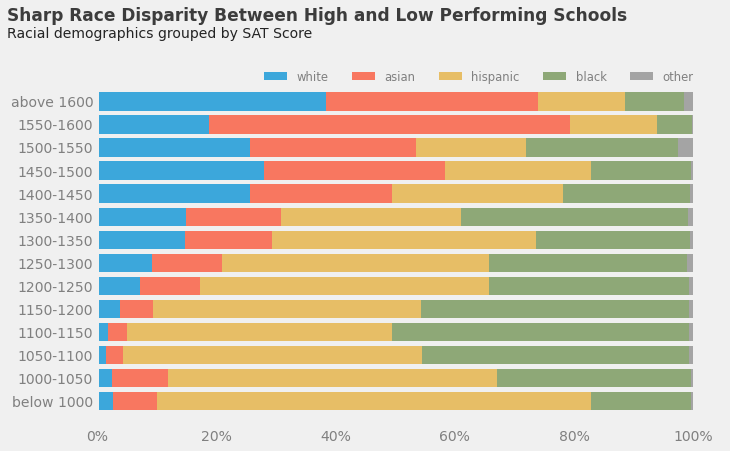

In [45]:
#_______________________________________________________
#extract desired features
race_per = ["white_per","asian_per","hispanic_per","black_per"]
race_df = combined.loc[:,race_per + ["sat_score"]]
#_______________________________________________________
#create category names and endpoints for averaging intervals
categories = ['below 1000','1000-1050','1050-1100','1100-1150','1150-1200',
'1200-1250','1250-1300','1300-1350','1350-1400','1400-1450','1450-1500',
'1500-1550','1550-1600','above 1600']
endpoints = [1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600]
#_______________________________________________________
#properly label each entry with category 
race_df.loc[race_df['sat_score'] < endpoints[0],'bin'] = categories[0]
for i,item in enumerate(endpoints):
    if i < len(endpoints) - 1:
        race_df.loc[(item<=race_df["sat_score"]) & (race_df["sat_score"]<endpoints[i+1]) ,'bin'] = categories[i+1]
    else: 
        race_df.loc[race_df["sat_score"]>item, 'bin'] = categories[i+1]

#_______________________________________________________
#generate data for plotting, as in previous code cell
plot_data = pd.DataFrame([], columns=race_per, index=range(0,len(categories)))
for bin,cat in enumerate(categories):
    for race in race_per:
        plot_data.loc[bin,race] = np.round(race_df.loc[race_df.loc[:,'bin'] == cat, race].mean(),2) 
plot_data['other_per'] = 100.00 - plot_data.sum(axis = 1)
#_______________________________________________________
#initialize plot
x_axis = categories
fig,ax = plt.subplots(figsize = (10,6))
#_______________________________________________________
#create plot, stacking bars ontop of each other
for i,race in enumerate(race_per + ['other_per']):
    if i == 0:
         ax.barh(x_axis, plot_data[race], alpha = .75,label = race[:-4])
    else:
        ax.barh(x_axis, plot_data[race], left = plot_data.cumsum(axis = 1).iloc[:,i-1],alpha = .75,label = race[:-4])
#_______________________________________________________
#remove grid, format tick colors and labels, format legend
ax.tick_params(colors = 'grey', which = 'both')
ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'])
ax.grid(visible= False, axis = 'y')
ax.grid(visible= False, axis = 'x')
leg = ax.legend(bbox_to_anchor=([0.25, .95, 0, 0]), ncol=5, frameon=False, fontsize = 'small')
#_______________________________________________________
#place title and subtitle
for text in leg.get_texts():
    text.set_color('gray')
ax.text(-15,16.5, 'Sharp Race Disparity Between High and Low Performing Schools', weight = 'bold', size = 17, alpha = .75)
ax.text(-15,15.75, 'Racial demographics grouped by SAT Score', alpha = .85)

In the above, we see that schools which score increasingly higher on the SAT are made up of increasingly larger proportions of white and asian students. While the proportion of black students does not strictly decrease as score increases (as it did in the last graph), we notice instead that the proportion of hispanic students tends to decrease as score increases. In particular, we see that hispanic students make up a majority of the population in the schools which scored below 1000. 

One aspect that could be related to this is whether certain students are english language learners. Luckily, we have the percentage of english language learners for each school. Let's take a look at SAT score vs. English language learner percentage. 

/tmp/ipykernel_397/76450323.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','1000','','1400','','1800', '','2200'])


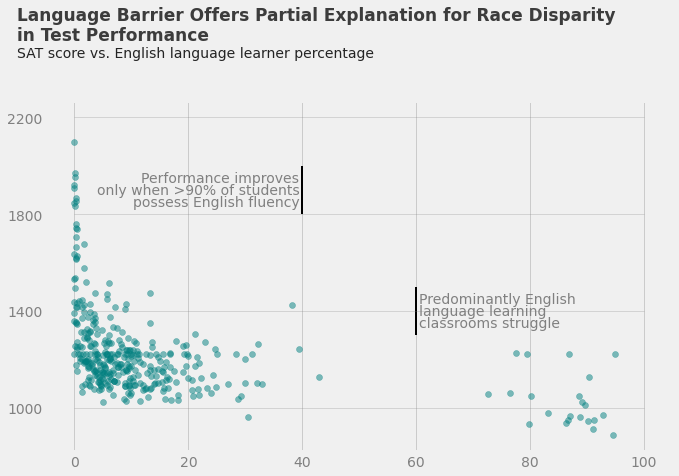

In [50]:
#_______________________________________________________
#initialize plot
fig,ax = plt.subplots(figsize = (10,6))
#___________________________________________________________
#create descired scatter plot
ax.scatter(combined["ell_percent"], combined["sat_score"],color = "teal", alpha = .5)
#___________________________________________________________
#remove grids
ax.grid(visible= False, axis = 'y')
#___________________________________________________________
#place title and subtitle
ax.text(-10,2600, 'Language Barrier Offers Partial Explanation for Race Disparity', weight = 'bold', size = 17, alpha = .75)
ax.text(-10,2520, 'in Test Performance', weight = 'bold', size = 17, alpha = .75)
ax.text(-10,2450, 'SAT score vs. English language learner percentage', alpha = .85)
#_______________________________________________________
#highlight higher performance only when ell_percent is small
ax.text(39.5,1950, 'Performance improves', color = 'grey', ha='right', va='center')
ax.text(39.5,1900, 'only when >90% of students', color = 'grey', ha='right', va='center')
ax.text(39.5,1850, 'possess English fluency', color = 'grey', ha='right', va='center')
ax.vlines(40, ymin = 1800, ymax = 2000,color = 'black',linewidth = 2)
#_______________________________________________________
#emphasize lower maximum performance when ell_percent is large
ax.text(60.5,1450, 'Predominantly English', color = 'grey', ha='left', va='center')
ax.text(60.5,1400, 'language learning', color = 'grey', ha='left', va='center')
ax.text(60.5,1350, 'classrooms struggle', color = 'grey', ha='left', va='center')
ax.vlines(60, ymin = 1300, ymax = 1500,color = 'black',linewidth = 2)
#_______________________________________________________
#fix tick color, labels, and add horizontal lines in proper places
ax.tick_params(colors = 'grey', which = 'both')
ax.set_yticklabels(['','1000','','1400','','1800', '','2200'])
ax.hlines([1000,1400,1800,2200], xmin = 0,xmax=100, linewidth = .5, color = 'grey',alpha = .5)

This plot shows clearly that schools with higher percentages of English language learners are unlikely to do as well. This offers a partial explanation to the ealier trend showing that poorly performing schools tend to have a large proportion of hispanic students, many of which are English language learners. 

Interestingly, notice that the performance doesn't gradually increase as the percentage of English language learners decreases. Instead, we observe a similar performance grouping among schools with English language learner percentage higher than about 7.5%. This suggest that the lower average score isn't just affecting the individuals learning english, but rather the entire classroom. 

# Conslusion 
In this notebook, we cleaned and combined over 7 different datasets containing information about SAT scores among NYC High Schools. After carefully cleaning and combining the data, we were to investigate some interesting factors related to SAT test performance. 

We made the following observations about NYC SAT test takers:

- Student's who feel unsafe at school and/or in the classroom are unable to obtain high scores.
- Black students are disproportionately affected by unsafe classrooms, while white and asian students are more likely to inhabit safe classrooms.  
- Classrooms which have a considerable percentage of English language learners are typically unable to score above 1400, while all schools with average scores above 1600 consist of nearly no English language learners. 

We see that SAT score is greatly impacted by many factors which are simply out the students' control. Avoiding these factors does not neccesarily ensure a good SAT performance. However, the presence of such obstacles to learning, such as language barriers in the classroom or lack of safety, does prevent students from acheiving scores as high as their more fortunate counterparts. 